In [208]:
from __future__ import print_function, division


import skimage as sk
import skimage.io as skio
from scipy.signal import *
import cv2
import scipy
import torch.nn as nn
import imgaug

import os
import torch
import pandas as pd
from skimage import io, transform
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import numpy as np
from skimage.color import rgb2gray
import pandas as pd
from PIL import Image
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

## Global Parameters

In [59]:
input_dimensions = (300, 300)

## Loading

In [63]:
metadata = pd.read_csv('dataset/HAM10000_metadata')
raw_annotation = pd.read_csv('raw_annotation.csv')

In [64]:
im = skio.imread('HAM10000_images_part_1/ISIC_0028346.jpg')
im.shape

(450, 600, 3)

## Annotation Data

In [71]:
raw_annotation['x'][raw_annotation['x']<0]=0
raw_annotation['y'][raw_annotation['y']<0]=0
raw_annotation['x'][raw_annotation['x']>99999]=0
raw_annotation['y'][raw_annotation['y']>99999]=0
raw_annotation['w'][(raw_annotation['w'] == 100) * (raw_annotation['h'] == 100)]['w']=599
raw_annotation['w'][(raw_annotation['w'] == 100) * (raw_annotation['h'] == 100)]['h']=449
raw_annotation['w'][raw_annotation['w']>=600]=599
raw_annotation['h'][raw_annotation['h']>=450]=449

(<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>)

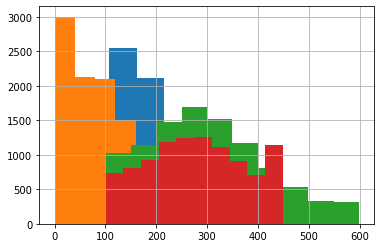

In [72]:
raw_annotation['x'].hist(), raw_annotation['y'].hist(), raw_annotation['w'].hist(), raw_annotation['h'].hist()

In [73]:
annotation = raw_annotation
raw_annotation.to_csv('annotation.csv')

## Data Augmentation

In [97]:
nimages = 0
mean = torch.zeros(3)
std = torch.zeros(3)
working_directory = [x for x in os.listdir() if 'HAM10000_images' in x]
for directory in working_directory:
    for image_path in os.listdir(directory):
        nimages += 1
        # Compute mean and std here
        mean += transforms.ToTensor()(Image.open(directory + '/' + image_path)).mean(axis=1).mean(axis=1)
        std += transforms.ToTensor()(Image.open(directory + '/' + image_path)).std(axis=1).std(axis=1)

# Final step
mean /= nimages
std /= nimages

In [105]:
torch.load('mean-std.pt')

{'mean': tensor([0.7635, 0.5461, 0.5705]),
 'std': tensor([0.0366, 0.0464, 0.0504])}

In [133]:
annotation['image_id'] = annotation['path'].str.split('/').agg(lambda x: x[1]).agg(lambda x: x[:-4])

In [137]:
final = pd.merge(annotation, metadata, left_on='image_id', right_on='image_id')
final = pd.get_dummies(final, columns=['dx'])
final.to_csv('final.csv')

## Dataset

In [374]:
class SkinData(Dataset):
    def __init__(self, root_dir, data, transform=None,  mode='train'):
        self.root_dir = root_dir
        self.data = pd.read_csv(data)
        self.transform = transform
        self.mode = mode
    
    def __len__(self):
        self.length = len(self.data)
        return self.length

    def __getitem__(self,  idx):
        """
        Obtains an 'image' and 'target' as a tuple
        ##INPUT##
        idx: (int) item id
        
        ##OUTPUT##
        image: (tensor) image after transformations
        target: (dictionary) contains the targets
            - 'bbox': (list) [xmin, ymin, xmax, ymax]
            - 'labels': (tensor) (7,) One Hot Encoded Vector for the Disease Diagnoses
            - 'area': (float/int) area of bounding box
            - 'id': idx
        """
        datapoint = self.data.iloc[idx]
        image = Image.open(datapoint['path'])
        target = {}
        minx = datapoint['x']
        miny = datapoint['y']
        w = datapoint['w']
        h = datapoint['h']
        maxx = minx + w
        maxy  = miny + h

        target['area'] = w * h
        target['labels'] = torch.tensor(datapoint[-7:])
        target['bbox'] = torch.tensor([minx, miny, maxx, maxy])
        target['idx'] = idx
        
        if self.transform is not None:
            image, target = self.transform((np.array(image), target))

        return image, target

In [375]:
dataset = SkinData('/', 'final.csv')
train_data, test_data = torch.utils.data.random_split(dataset,[int(0.8 * len(dataset)), int(0.2 * len(dataset))],  generator=torch.Generator().manual_seed(42))

In [376]:
import imageio
import imgaug as ia
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

In [381]:
meta=torch.load('mean-std.pt')
res = 300
def Resizing(resize = (300, 300)):
    def Resize(it):
        """
        Resizes images according to the resize dimensions
        image: (array) Image
        resize: (tuple of integers) New dimensions
        target: (Dictionary) Containing BBox, Area, Labels and Index

        Returns normalized_image, target
        """
        image, target = it
        resize = res
        new_target = target.copy()
        bbs = BoundingBoxesOnImage([BoundingBox(x1=new_target['bbox'][0].item(), y1=new_target['bbox'][1].item(), x2=new_target['bbox'][2].item(), y2=new_target['bbox'][3].item())], image.shape)
        img = ia.imresize_single_image(np.array(image), resize)
        new_bbs = bbs.on(img)
        bbox = [new_bbs[0].x1, new_bbs[0].y1, new_bbs[0].x2, new_bbs[0].y2]
        new_target['bbox'] = bbox
        new_target['area'] = (new_bbs[0].x2 - new_bbs[0].x1) * (new_bbs[0].y2 - new_bbs[0].y1)
        return img, new_target
    return Resize

def ToTensor(it):
    """
    Wrapper for converting image to tensor
    
    Returns tensor_image, target
    """
    image, target = it
    return transforms.ToTensor()(image), target

def Normalizer(meta):
    def normalize(it):
        """
        Normalizes images according to the meta['mean'] and meta['std']
        image: (Tensor) Image
        target: (Dictionary) Containing BBox, Area, Labels and Index

        Returns normalized_image, target
        """
        image, target = it
        function = torchvision.transforms.Normalize(
            mean=meta['mean'],
            std=meta['std'],
        )
        img = function(image)
        return img, target
    return normalize

In [378]:
meta = torch.load('mean-std.pt')

dataset = SkinData('/', 'final.csv', transform=transforms.Compose([Resize, ToTensor, normalize]))